In [3]:
import pandas as pd
file_path = '../data/orders.csv'
data = pd.read_csv(file_path)
print(f"Loaded {len(data)} records")
data.head()



Loaded 7 records


,customer_id,phone,order_id,status,address,date,cancel_reason
0,C001,1712345678,O001,delivered,Dhaka,2025-06-01,NaN
1,C002,1812345679,O002,canceled,Chittagong,2025-06-02,wrong address
2,C001,1712345678,O003,canceled,Dhaka,2025-06-04,refused to accept
3,C003,1998765432,O004,failed,Barisal,2025-06-05,phone switched off
4,C001,1712345678,O005,canceled,Dhaka,2025-06-06,wrong address


In [4]:
# শুধু suspicious অর্ডার (যাদের status canceled বা failed)
suspicious = data[data['status'].isin(['canceled', 'failed'])]
suspicious.head()


,customer_id,phone,order_id,status,address,date,cancel_reason
1,C002,1812345679,O002,canceled,Chittagong,2025-06-02,wrong address
2,C001,1712345678,O003,canceled,Dhaka,2025-06-04,refused to accept
3,C003,1998765432,O004,failed,Barisal,2025-06-05,phone switched off
4,C001,1712345678,O005,canceled,Dhaka,2025-06-06,wrong address
6,C002,1812345679,O007,failed,Chittagong,2025-06-08,refused to accept


In [5]:
# কতবার suspicious অর্ডার (canceled/failed) করেছে, সেটা গোনা
suspicious_counts = suspicious.groupby('customer_id').size().reset_index(name='suspicious_orders')
suspicious_counts


,customer_id,suspicious_orders
0,C001,2
1,C002,2
2,C003,1


In [6]:
# canceled অর্ডার গুলোতে কতবার reason দিয়েছে
cancel_reason_counts = suspicious[suspicious['status'] == 'canceled'].groupby('customer_id')['cancel_reason'].apply(lambda x: x.notna().sum()).reset_index(name='cancel_reasons')
cancel_reason_counts


,customer_id,cancel_reasons
0,C001,2
1,C002,1


In [7]:
# merge করে fraud_score বের করা
fraud_summary = pd.merge(suspicious_counts, cancel_reason_counts, on='customer_id', how='left')
fraud_summary['cancel_reasons'] = fraud_summary['cancel_reasons'].fillna(0).astype(int)
fraud_summary['fraud_score'] = fraud_summary['suspicious_orders'] + fraud_summary['cancel_reasons']
fraud_summary = fraud_summary.sort_values(by='fraud_score', ascending=False)
fraud_summary


,customer_id,suspicious_orders,cancel_reasons,fraud_score
0,C001,2,2,4
1,C002,2,1,3
2,C003,1,0,1


In [8]:
# fraud_score 2 বা তার বেশি — সন্দেহভাজন কাস্টমার
fraud_customers = fraud_summary[fraud_summary['fraud_score'] >= 2]
fraud_customers


,customer_id,suspicious_orders,cancel_reasons,fraud_score
0,C001,2,2,4
1,C002,2,1,3


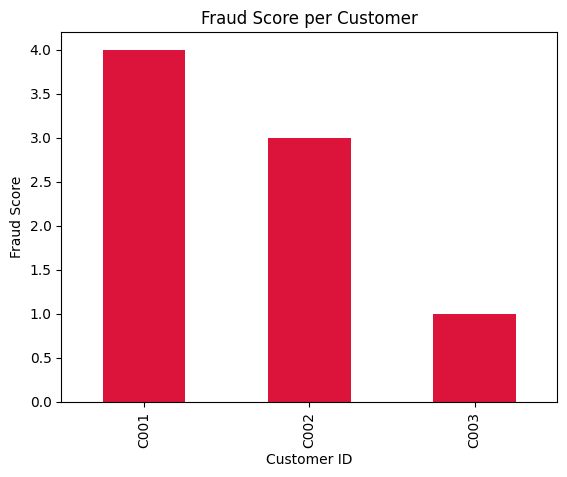

In [9]:
import matplotlib.pyplot as plt

fraud_summary.set_index('customer_id')['fraud_score'].plot(kind='bar', color='crimson')
plt.title('Fraud Score per Customer')
plt.xlabel('Customer ID')
plt.ylabel('Fraud Score')
plt.show()
